In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install torchtext==0.6.0
#!pip install py-rouge

     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 1.0MB 4.7MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [0]:
import pandas as pd
import numpy as np

import nltk
nltk.download('punkt')
import os

import nltk
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Bleu score using torch text

Computes the BLEU score between a candidate translation corpus and a references translation corpus. Based on https://www.aclweb.org/anthology/P02-1040.pdf 
and nltk (sentence bleu)

In [0]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data):
    trgs = []
    pred_trgs = []

    nltk_score = []
    nltk_corpus_score = []
    for index, row in data.iterrows():
     
      src_trg_1 = row['headline']
      src_trg = nltk.word_tokenize(src_trg_1)
      
      pred_trg_1 = row['pred_headline']
      pred_trg = nltk.word_tokenize(pred_trg_1)

      #cut off <eos> token
      pred_trg = pred_trg[:-3]
         
      pred_trgs.append(pred_trg)
      trgs.append([src_trg])

      sc = nltk.translate.bleu_score.sentence_bleu([src_trg], pred_trg)
      sc_1 = nltk.translate.bleu_score.corpus_bleu([[src_trg]], [pred_trg])
      
      nltk_score.append(sc)
      nltk_corpus_score.append(sc_1)
    
    score_avg = np.sum(nltk_score)/len(nltk_score)
    score_avg_corpus = np.sum(nltk_corpus_score)/len(nltk_corpus_score)

    return bleu_score(pred_trgs, trgs) , score_avg , score_avg_corpus , nltk_score

Issue with nltk score calculation

> when number of words increased in predicted words and references remain the same the bleu score went up with nltk sentence_bleu_score
> so below few python codes show what is the issue and code to get true bleu score at corpus level
> Later found nltk have a corpus levle nltk score



In [0]:
import warnings
warnings.filterwarnings('ignore')

import nltk.translate.bleu_score as bleu

In [0]:
reference = [
    'this is a ship'.split()
]

translation = 'ship'.split()
print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

translation = 'ship ship'.split()
print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

translation = 'ship ship ship'.split()
print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

BLEU score: 0.049787068367863944
BLEU score: 0.30934850332660563
BLEU score: 0.5444460596606694




```
Due to the above issue iwth nltk's sentence bleu score of counting same word multiple times and causing the score to increase 
we implemented below strategy to look for bleu score which takes care of multiple reference statements 
and putting a bravity penality- [source]: https://ariepratama.github.io/Introduction-to-BLEU-in-python/
```



In [0]:
import numpy as np
from nltk import ngrams
from collections import Counter

In [0]:
def count_ngram(unigram, ngram=1):
  return Counter(ngrams(unigram, ngram))

def count_clip_ngram(translation_u, list_of_reference_u, ngram=1):
    res = dict()
    
    # retrieve hypothesis counts
    ct_translation_u = count_ngram(translation_u, ngram=ngram)

    # retrieve translation candidate counts
    for reference_u in list_of_reference_u:
        ct_reference_u = count_ngram(reference_u, ngram=ngram)
        for k in ct_reference_u:
            if k in res:
                res[k] = max(ct_reference_u[k], res[k])
            else:
                res[k] = ct_reference_u[k]

    return {
        k: min(ct_translation_u.get(k, 0), res.get(k, 0)) 
        for k in ct_translation_u
    }

def modified_precision(translation_u, list_of_reference_u, ngram=1):
    #print(ngram)
    ct_clip = count_clip_ngram(translation_u, list_of_reference_u, ngram)

    ct = count_ngram(translation_u, ngram)
    
    return sum(ct_clip.values()) / float(max(sum(ct.values()), 1))

def closest_ref_length(translation_u, list_of_reference_u):
    len_trans = len(translation_u)
    closest_ref_idx = np.argmin([abs(len(x) - len_trans) for x in list_of_reference_u])
    return len(list_of_reference_u[closest_ref_idx])

def brevity_penalty(translation_u, list_of_reference_u):
    c = len(translation_u)
    r = closest_ref_length(translation_u, list_of_reference_u)
    
    if c > r:
        return 1
    else:
        return np.exp(1 - float(r)/c)

def bleu_score_fun(translation_u, list_of_reference_u, W=[0.25 for x in range(4)]):
    bp = brevity_penalty(translation_u, list_of_reference_u)
    modified_precisions = [
        modified_precision(translation_u, list_of_reference_u, ngram=ngram)
        for ngram, _ in enumerate(W,start=1)
    ]
    score = np.sum([
        wn * np.log(modified_precisions[i]) if modified_precisions[i] != 0 else 0 for i, wn in enumerate(W)
    ])
    
    return bp * np.exp(score)

In [0]:
def calculate_bleu_custom(data):
    trgs = []
    pred_trgs = []
    
    nltk_score = []
    count = 0
    
    for index, row in data.iterrows():
      src_trg_1 = row['headline']
      src_trg = nltk.word_tokenize(src_trg_1)
      
      pred_trg_1 = row['pred_headline']
      pred_trg = nltk.word_tokenize(pred_trg_1)

      #cut off <eos> token
      pred_trg = pred_trg[:-3]

      pred_trgs.append(pred_trg)
      trgs.append([src_trg])

      if len(pred_trg) != 0:
        sc = bleu_score_fun(pred_trg, [src_trg])
        nltk_score.append(sc)
    
    score_avg = np.sum(nltk_score)/len(nltk_score)

    return  nltk_score, score_avg

In [0]:
def get_count(scores, threshold):
  count = 0 
  for i in scores:
    if i >= threshold:
      count = count +1
  return count


`Recall in the context of ROUGE simply means how much of the reference summary is the system summary recovering or capturing -> number of overlapping words /total_words in reference summary`

`A machine generated summary (system summary) can be extremely long, capturing all words in the reference summary. Hence, Precision`



```
precision = #overlapping words/total words in system summary

The reason one would use ROUGE-1 over or in conjunction with ROUGE-2 (or other finer granularity ROUGE measures), is to also show the fluency of the summaries or translation.
```



In [0]:
!pip install rouge

Rouge-n Score:

In [0]:
from rouge import Rouge

rouge = Rouge()

def calculate_rogue(data):
  rogue_scores = []
  for index, row in data.iterrows():
    
    src_trg = row['headline']
    pred_trg_1 = row['pred_headline']

    
    #cut off <eos> token
    pred_trg = pred_trg_1[:-6]

    if(len(pred_trg) != 0):
      sc = rouge.get_scores(pred_trg, src_trg, avg= True)
      rogue_scores.append(sc)
    
  return rogue_scores

In [0]:
def get_rouge_1_scores(score):
  f_scores = []
  p_scores = []
  r_scores = []
  #print(score)
  for s in score:
    f_scores.append(s['rouge-1']['f'])
    p_scores.append(s['rouge-1']['p'])
    r_scores.append(s['rouge-1']['r'])
  
  return f_scores, p_scores, r_scores

Below code to call above for different predictions 

In [0]:
output_lstm = pd.read_csv(r'/content/drive/My Drive/IDS_576_Project/score/Attention_LSTM_Pred.csv',sep='\t',header='infer',index_col = False)
output_lstm = output_lstm.astype(str)
rows, columns = output_lstm.shape

output_lstm

,text,headline,pred_headline
0,found top part screen tap nas device open shar...,launch webaccess app tap nas list select nas s...,open files files open files files files files ...
1,student start really look forward part lesson ...,allot five minutes end lesson game time choose...,take game game game game game game <EOS>
2,creates third loop slip top ribbon length use ...,select ribbon tied bow fold make two loops sin...,draw first paper draw first first draw <EOS>
3,microsoft turned auto syncing default install ...,open onenote program make edits note shared no...,open open open click click click click click c...
4,think jokes going use special effects going us...,watch sources look jokes may use start plannin...,go hair go go <EOS>
...,...,...,...
14905,edit file extension windows need make sure fil...,make sure file extensions visible rename file ...,open file file open file file file file click ...
14906,easy way print flags internet images photocopy...,create flags nations number flags give players...,write sure make write make write <EOS>
14907,right sketch layer file first create backgroun...,make layers outline drawing get basic colors,open image want open click click click click i...
14908,created skype account yet within skype app alr...,open skype app tap create account verify accou...,open google app app tap tap tap tap tap tap ta...


In [0]:
output_keras_lstm = pd.read_csv(r'/content/drive/My Drive/IDS_576_Project/score/prediction_op_Keras.csv',sep='\t',header='infer',
                                index_col = False, names = ['text', 'headline', 'pred_headline'])
output_keras_lstm = output_keras_lstm.astype(str)
rows, columns = output_keras_lstm.shape

output_keras_lstm

,text,headline,pred_headline
0,text,orig_summ,pred_summ
1,always want make sure putting proper accent wo...,know your accents first find an example of the...,create new document in the text editor click ...
2,fill martini glass ice leave cool prepare drin...,chill the martini glass mix the ingredients cu...,chill the glass make the mixture make the mix...
3,lot websites whole lot information penguins lo...,educate yourself about dress in penguin colors...,get to know your friends and friends and fami...
4,official website many download mirrors provide...,download from the internet move the downloaded...,download the program open the downloaded file...
...,...,...,...
14996,attaching one end watch strap case wrapping st...,measure the band bend down the top edge flaps ...,use the right hand to the left of the left ha...
14997,gives fresh look face,soak cotton balls in rose water and refrigerat...,make sure you have the right hand on your sid...
14998,absence brown spots fennel large old dry roast...,look for smooth white skin choose firm young f...,remove the tomatoes from the freezer store th...
14999,type cmd hit enter click ok example want ping ...,open the command window by clicking start then...,open the terminal type in the ip address ente...


In [0]:
output_gru = pd.read_csv(r'/content/drive/My Drive/IDS_576_Project/score/Attention_GRU_Pred.csv',sep='\t',header='infer',index_col = False)
output_gru = output_gru.astype(str)
rows, columns = output_gru.shape

output_gru

,text,headline,pred_headline
0,server go click log select option want click c...,go horse isle sign account upper right corner ...,go paypal account log account account scroll s...
1,yellow icon white ghost usually home screen bo...,open snapchat tap chat select chat take snap t...,tap snapchat tap photo tap tap tap tap tap pho...
2,handles moving image around need edit photo so...,opening program click page icon start looking ...,open image image click image picture click new...
3,dental relief wax available orthodontist local...,create small ball dental wax dry brace wire pu...,use wax wax wax wax wax wax wax wax wax wax wa...
4,pinometers water make water using shovel know ...,attract newgat garden buy chili seed chili pep...,place one one go go place go one go one go one...
...,...,...,...
14904,always backup important files wiping hard driv...,backup system anything enable root user option...,open apple click system click system click sys...
14905,check stats first time battle rivals friends s...,choose starter wisely level get first town go ...,get level level mon level get make sure breed ...
14906,make sure know exactly person appropriate pers...,learn official name find mailing address offic...,contact letter letter letter letter letter let...
14907,process vary depending scanner type computer u...,scan document computer open scanned document r...,create new file create new file create new nam...


In [0]:
bleu_score_out_lstm , nltk_bleu_score_lstm , nltk_corpus_bleu_score_lstm , nltk_score_lstm = calculate_bleu(output_lstm)

print(f'BLEU score = {bleu_score_out_lstm*100:.2f}')

print(f'BLEU score_NLTK = {nltk_bleu_score_lstm:.2f}')

print(f'BLEU score_NLTK_CORPUS = {nltk_corpus_bleu_score_lstm:.2f}')

BLEU score = 0.27
BLEU score_NLTK = 0.13
BLEU score_NLTK_CORPUS = 0.13


In [0]:
threshold = 0.8

nltk_fun_score_lstm , nltk_fun_avg_lstm = calculate_bleu_custom(output_lstm)
#scores_fun_lstm , nltk_bleu_score_fun = calculate_bleu_custom(output_lstm)
count_lstm = get_count(nltk_fun_score_lstm, threshold)

print(nltk_fun_avg_lstm)
print(count_lstm)

0.27338979210992054
960


In [0]:
bleu_score_out_lstm_keras , nltk_bleu_score_lstm_keras , nltk_corpus_bleu_score_lstm_keras , nltk_score_lstm_keras = calculate_bleu(output_keras_lstm)

print(f'BLEU score = {bleu_score_out_lstm_keras*100:.2f}')

print(f'BLEU score_NLTK = {nltk_bleu_score_lstm_keras:.2f}')

print(f'BLEU score_NLTK_CORPUS = {nltk_corpus_bleu_score_lstm_keras:.2f}')

BLEU score = 3.44
BLEU score_NLTK = 0.28
BLEU score_NLTK_CORPUS = 0.28


In [0]:
nltk_fun_score_lstm_keras , nltk_fun_avg_lstm_keras = calculate_bleu_custom(output_keras_lstm)

count_lstm_keras = get_count(nltk_fun_score_lstm_keras, threshold)

print(nltk_fun_avg_lstm_keras)
print(count_lstm_keras)

0.33203591401536603
668


In [0]:
bleu_score_out_gru , nltk_bleu_score_gru , nltk_corpus_bleu_score_gru , nltk_score_gru = calculate_bleu(output_gru)

print(f'BLEU score = {bleu_score_out_gru*100:.2f}')

print(f'BLEU score_NLTK = {nltk_bleu_score_gru:.2f}')

print(f'BLEU score_NLTK_CORPUS = {nltk_corpus_bleu_score_gru:.2f}')

BLEU score = 0.83
BLEU score_NLTK = 0.19
BLEU score_NLTK_CORPUS = 0.19


In [0]:
nltk_fun_score_gru , nltk_fun_avg_gru = calculate_bleu_custom(output_gru)
#scores_fun_lstm , nltk_bleu_score_fun = calculate_bleu_custom(output_lstm)
count_gru = get_count(nltk_fun_score_gru, threshold)

print(nltk_fun_avg_gru)
print(count_gru)

0.36589831427089026
1836


In [0]:
score_lstm = calculate_rogue(output_lstm)

In [0]:
score_lstm_keras = calculate_rogue(output_keras_lstm)

In [0]:
score_gru = calculate_rogue(output_gru)



```
F score = 2*Bleu*rouge / bleu + rouge
show avg F score
```



In [0]:
f_lstm, p_lstm , r_lstm = get_rouge_1_scores(score_lstm)
f_lstm_keras, p_lstm_keras , r_lstm_keras = get_rouge_1_scores(score_lstm_keras)
f_gru, p_gru , r_gru = get_rouge_1_scores(score_gru)

In [0]:
print(f_lstm)

print(f_lstm_keras)

print(f_gru)

[0.0, 0.2264150920469918, 0.0, 0.10256409830374771, 0.060606058475665824, 0.10909090635371908, 0.19999999651250003, 0.0, 0.37499999517578125, 0.043478257722117435, 0.0, 0.0, 0.11111110611111134, 0.0434782564744806, 0.0, 0.04878048566329575, 0.0, 0.30508474272910086, 0.0, 0.043478258601134336, 0.0, 0.0, 0.06666666222222252, 0.0, 0.058823524480969266, 0.15789473322714692, 0.10526315437365354, 0.0, 0.0, 0.04545454277892578, 0.13333332888888905, 0.0, 0.0, 0.0, 0.11111110617283973, 0.15999999704800005, 0.0, 0.06896551486325811, 0.22222221728395072, 0.0, 0.17647058325259532, 0.22222221852839513, 0.13559321597242188, 0.2222222190895062, 0.0, 0.09523809115646274, 0.19047618639455788, 0.0, 0.07999999596800021, 0.044444441244444674, 0.0, 0.0, 0.0, 0.1999999950500001, 0.14285713795918387, 0.19999999580000008, 0.0, 0.0, 0.09999999580000019, 0.0, 0.11111110709876558, 0.11538461204881664, 0.0, 0.0, 0.0, 0.046511625505678875, 0.09090908628099197, 0.2941176421280277, 0.0, 0.2962962918518519, 0.0571428

Plot: Code to show how many were exactly matched or how many got rouge score greater than some threshold

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def plot_1(data, xlabel, ylabel, title):
  values, base = np.histogram(data, bins=40)
  cumulative = np.cumsum(values)
  perc = cumulative/150 ##(check the length and divide by that *100)
  
  # plot the cumulative function
  plt.plot(perc,base[:-1], c='blue')
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  
  plt.show()

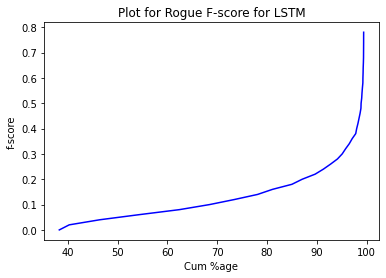

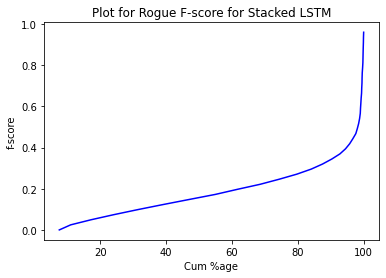

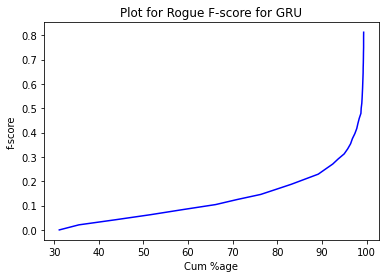

In [0]:
plot_1(f_lstm, "Cum %age", "f-score", "Plot for Rogue F-score for LSTM") 
plot_1(f_lstm_keras, "Cum %age", "f-score", "Plot for Rogue F-score for Stacked LSTM")
plot_1(f_gru, "Cum %age", "f-score", "Plot for Rogue F-score for GRU")

In [0]:
def examples_print(f_data, data, threshold = 0.9):
  for i in range(0,len(f_data)):
  #print(i)
    if f_data[i] > threshold:
      print(len(data.iloc[i]['text']))
      print(data.iloc[i]['headline'])
      print(data.iloc[i]['pred_headline'])

In [0]:
examples_print(f_lstm, output_lstm, 0.7)

328
open iphone settings tap general tap accessibility tap zoom slide smart typing switch position
open iphone settings tap general tap slide tap slide position <EOS>
128
acquire pot gather ingredients needed make candy ingredients rucksack walk pot kitchen counter choose ingredients need recipe
acquire pot gather ingredients needed make ingredients pot rucksack kitchen ingredients choose ingredients <EOS>
225
open iphone settings tap general tap accessibility scroll tap audio descriptions slide toggle switch position
open iphone settings tap general tap accessibility tap slide tap slide tap position <EOS>
128
acquire pot gather ingredients needed make candy ingredients rucksack walk pot kitchen counter choose ingredients need recipe
acquire pot gather ingredients needed make ingredients pot pot kitchen ingredients choose ingredients <EOS>


In [0]:
examples_print(f_lstm_keras, output_keras_lstm, 0.9)

436
learn that you need level summoning to create spirit spider pouch gather the required items to make one pouch ensure that the items needed for the pouch are in your inventory travel to any summoning obelisk click on the obelisk decide what you want to do with the pouches 
 learn that you need level summoning to create pouch gather the required items to make one pouch ensure that the items needed for the pouch are in the pouch travel to any summoning obelisk click on the obelisk decide what you want to do with the pouches
294
acquire matches get an have the in your rucksack start bonfire choose the that you need for the recipe 
 acquire matches get have the in your rucksack start bonfire choose the that you need for the recipe
67
do to repetitions of this exercise per set in order to start seeing feeling results aim to do sets days week for weeks 
 do repetitions of this exercise per set in order to start seeing feeling results aim to do sets days week for weeks
209
acquire an oven 

In [0]:
examples_print(f_gru, output_gru, 0.7)

140
acquire knife set gather ingredients needed make rice ball ingredients rucksack walk knife set kitchen counter choose ingredients need recipe
acquire frying pan gather ingredients needed rucksack walk kitchen counter choose ingredients need recipe <EOS>
195
open iphone settings scroll tap messenger tap location tap never
open iphone settings scroll tap tap tap tap tap <EOS>
167
bake book degrees fahrenheit hours let cool really hot cool stash back books invite friends tear
call emergency call <EOS>
451
protect anyone else involved best influence manipulator distance person try keep peace aware may need actively disconnect person equally aware everything might alright eventually
get conversation get <EOS>
267
head start load registry editor right click namespace key type ff aa key field click new key double click default
open registry editor open system open machine programs <EOS>
674
ask direct significant questions mark text urgent text something related interests use entertaining

In [0]:
np.sum(f_lstm)/len(f_lstm)

0.0931737606033378

In [0]:
np.sum(r_lstm)/len(r_lstm)

0.07418367656348948

In [0]:
np.sum(p_lstm)/len(p_lstm)

0.1583319699629693

In [0]:
np.sum(f_gru)/len(f_gru)

0.10510322729661722

In [0]:
np.sum(r_gru)/len(r_gru)

0.09882191764773011

In [0]:
np.sum(p_gru)/len(p_gru)

0.15609649931142972

In [0]:
np.sum(f_lstm_keras)/len(f_lstm_keras)

0.19760811639838927

In [0]:
np.sum(r_lstm_keras)/len(r_lstm_keras)

0.20453627925534007

In [0]:
np.sum(p_lstm_keras)/len(p_lstm_keras)

0.2290314216505903

In [0]:
from itertools import groupby

def CountFrequency(my_list, threshold):  
  # Creating an empty dictionary  
  freq = {} 
  for item in my_list:
    item = item*100
    if item < threshold:
      continue
    
    if (item in freq):
       
      freq[item] += 1
    else: 
      freq[item] = 1
  
  for key, value in freq.items(): 
    print ("% d : % d"%(key, value))